**Preliminares:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.misc import derivative

import nbimporter
import Funciones
import Coeficientes_de_Lanczos
from Funciones import Refinar_base

In [2]:
def M_Lanczos(N, H, Vec_Est_Base):
        
    Lanczos_Matrix = np.asmatrix(np.zeros([N,N]))
    a_coef = np.array([])
    b_coef = np.array([0])

    u_0 = Vec_Est_Base/np.linalg.norm(Vec_Est_Base)
    Lanczos_Matrix[:,0] = u_0
    
    for k in range(1,N):
    
        u_kminus2 = Lanczos_Matrix[:,k-2]
        u_kminus1 = Lanczos_Matrix[:,k-1]
        b_kminus1 = b_coef[k-1]

        a_kminus1 = float(np.transpose(u_kminus1)@H@u_kminus1)
        if(k ==1):
            u_k = (H - np.identity(N)*a_kminus1)@u_kminus1
        else:
            u_k = (H - np.identity(N)*a_kminus1)@u_kminus1 - b_kminus1*u_kminus2
            
        if(np.isclose(np.linalg.norm(u_k),0)): break
            
        b_k = float(np.linalg.norm(u_k))
        u_k = u_k/b_k
        Lanczos_Matrix[:,k] = u_k

        a_coef = np.append(a_coef, a_kminus1)
        b_coef = np.append(b_coef,b_k)
    
    Lanczos_Matrix = Lanczos_Matrix[:,:k]
    Lanczos_Matrix, a_coef, b_coef = Refinar_base(Lanczos_Matrix, a_coef, b_coef, H)
    
    return Lanczos_Matrix, a_coef, b_coef, H

Intentemos calcular los coeficientes de lanczos directamente al aplicar el algoritmo de Lanczos y comparemos con el código que ya se que funciona. Para esto tomemos como ejemplo el siguiente quench:

In [3]:
N = 50 #Intentemos con N pequeños solo para ver que sucede
delta_i = -0.5
delta_f = 0.5

D_i, U_i, H_i = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_i))
D_f, U_f, H_f = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_f))

Vec_Est_Base, lambda_Base = Funciones.Estado_Base(D_i,U_i)

In [4]:
Lanczos_Matrix, a, b, H = M_Lanczos(N, H_f, Vec_Est_Base)

In [5]:
a,b

(array([-0.97809545,  0.85241969,  0.17025215, -0.18624278,  0.19152942,
        -0.20747585,  0.21290229, -0.22979263,  0.23573166, -0.25483849,
         0.26177899, -0.28482354,  0.29345365, -0.3229724 ,  0.33435811,
        -0.37449405,  0.39047679, -0.44883024,  0.47301981, -0.56566238,
         0.60641054, -0.7749116 ,  0.8571973 , -1.2537201 ]),
 array([0.        , 0.22171155, 0.41852386, 0.49800898, 1.49329523,
        0.49750747, 1.49169641, 0.49693367, 1.48981497, 0.49623691,
        1.48745258, 0.49533119, 1.48427114, 0.49406669, 1.47966169,
        0.492162  , 1.47242216, 0.48902875, 1.45986562, 0.48324367,
        1.4348394 , 0.47053523, 1.372224  , 0.43220663, 1.11594639]))

Comparemos estos coeficientes con los del algoritmo de la M:

In [6]:
def M_sub_k_sup_n(k,n):    
    if(n == 0): return ((-1)**k)*M[k]
    else: return L_sub_k_sup_n(k, n-1) - L_sub_k_sup_n(n - 1, n-1)*(M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def L_sub_k_sup_n(k,n):   
    if(n == 0): return ((-1)**(k+1))*M[k+1]
    else: return (M_sub_k_sup_n(k+1, n)/M_sub_k_sup_n(n,n)) - (M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def a_n(n):
    return -1*L_sub_k_sup_n(n,n)

def b_n_cuadrado(n):
    if n==0: return 0
    else: return M_sub_k_sup_n(n,n)

def a_coef():
    coef = []
    for i in range(len(M)):
        try: coef.append(a_n(i))
        except: break
    return coef    

def b_coef_cuadrado():
    coef = []
    for i in range(len(M)):
        try: coef.append(b_n_cuadrado(i))
        except: break
    return coef   

In [7]:
def S(t):
    Vec_t = np.dot(linalg.expm((1j)*t*H_f), Vec_Est_Base)
    return complex(np.dot(Vec_t.T, Vec_Est_Base))

/home/joaco/anaconda3/envs/root_lab/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


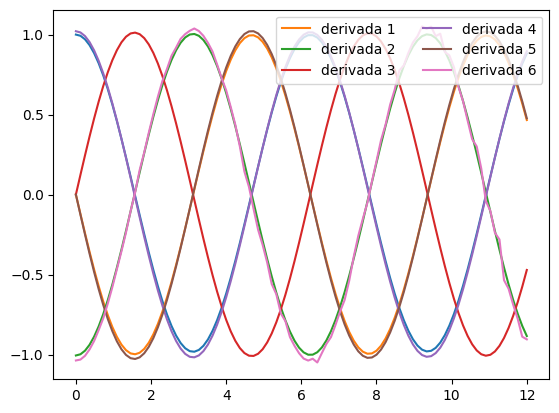

In [8]:
tiempos = np.linspace(0,12,100)
plt.plot(tiempos, [S(t_i) for t_i in tiempos])

M = [1]

for degree in range(1,7):
    
    Lprima = []
    for t in tiempos: 
        Lprima.append(derivative(S, x0 = t, dx= 0.01, n = degree , order = degree + degree%2 + 1))
        
    plt.plot(tiempos, Lprima, label = f'derivada {degree}')
    
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

plt.legend(loc = 'upper right', ncol=2)

In [9]:
M

[1,
 (-0.9780789546907711-0j),
 (1.0058182189265352-0j),
 (-0.9899472198163227+5.551115123125782e-11j),
 (1.0210566725454837-1.7347234759768069e-09j),
 (-1.0019569202102117-5.551115123125782e-07j),
 (1.0370593273023585-6.938893903907227e-05j)]

In [10]:
a_coef(), a

([(-0.9780789546907711+0j),
  (0.8524665998434411+1.1287393774240515e-09j),
  (0.17016708453895393-6.450002079752029e-05j)],
 array([-0.97809545,  0.85241969,  0.17025215, -0.18624278,  0.19152942,
        -0.20747585,  0.21290229, -0.22979263,  0.23573166, -0.25483849,
         0.26177899, -0.28482354,  0.29345365, -0.3229724 ,  0.33435811,
        -0.37449405,  0.39047679, -0.44883024,  0.47301981, -0.56566238,
         0.60641054, -0.7749116 ,  0.8571973 , -1.2537201 ]))

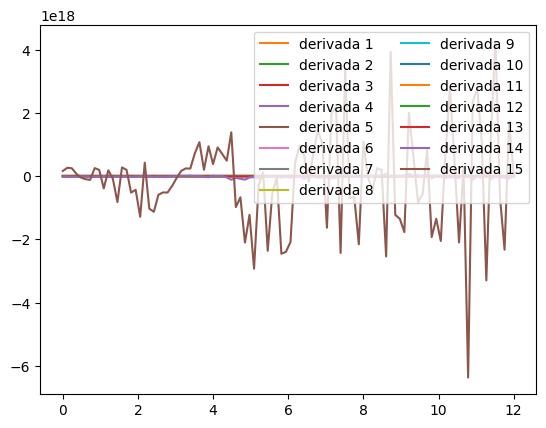

In [11]:
tiempos = np.linspace(0,12,100)
plt.plot(tiempos, [S(t_i) for t_i in tiempos])

M = [1]

for degree in range(1,16):
    
    Lprima = []
    for t in tiempos: 
        Lprima.append(derivative(S, x0 = t, dx= 0.01, n = degree , order = degree + degree%2 + 1))
        
    plt.plot(tiempos, Lprima, label = f'derivada {degree}')
    
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = degree + degree%2 + 1))

plt.legend(loc = 'upper right', ncol=2)

In [12]:
M

[1,
 (-0.9780789546907711-0j),
 (1.0058182189265352-0j),
 (-0.9899472198163227+5.551115123125782e-11j),
 (1.0210566725454837-1.7347234759768069e-09j),
 (-1.0019569202102117-5.551115123125782e-07j),
 (1.0370593273023585-6.938893903907227e-05j),
 (-1.024527684911902-0.13322676295501876j),
 (-26.64535259100375+1.1796119636642286j),
 (-38.16391647148975+3386.1802251067265j),
 (-499600.36108132027-218575.1579730776j),
 (34694.469519536135-136557432.02889422j),
 (-102029495963.05185-4343747583.845923j),
 (-398292510084.2748+3586020369539.2544j),
 (4105604745063828-34278135885301.7j),
 (874300631892310.5+1.6997514507011142e+17j)]

In [13]:
a_coef(), a

([(-0.9780789546907711+0j),
  (0.8524665998434411+1.1287393774240515e-09j),
  (0.17016708453895393-6.450002079752029e-05j),
  (47.24005809182035-384.14567094022766j),
  (-56.14579172716581+80.5815171355676j),
  (305.86284049015114+986.6508020429511j),
  (-333.78141369715735-710.476872926742j),
  (72.64411188022231+67.52634665645861j)],
 array([-0.97809545,  0.85241969,  0.17025215, -0.18624278,  0.19152942,
        -0.20747585,  0.21290229, -0.22979263,  0.23573166, -0.25483849,
         0.26177899, -0.28482354,  0.29345365, -0.3229724 ,  0.33435811,
        -0.37449405,  0.39047679, -0.44883024,  0.47301981, -0.56566238,
         0.60641054, -0.7749116 ,  0.8571973 , -1.2537201 ]))

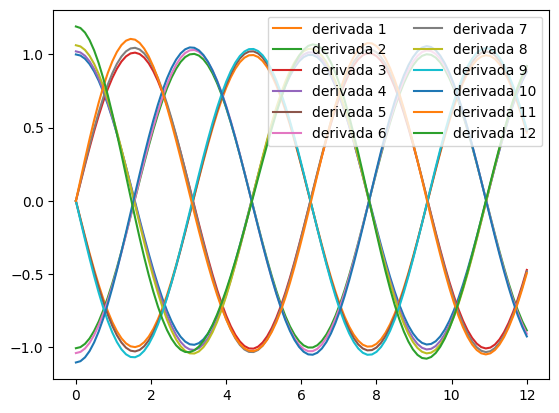

In [14]:
tiempos = np.linspace(0,12,100)
plt.plot(tiempos, [S(t_i) for t_i in tiempos])

M = [1]

for degree in range(1,13):
    
    Lprima = []
    for t in tiempos: 
        Lprima.append(derivative(S, x0 = t, dx= 0.3, n = degree , order = 6*degree + 1))
        
    plt.plot(tiempos, Lprima, label = f'derivada {degree}')
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.3, n = degree , order = 6*degree + 1))
    
plt.legend(loc = 'upper right', ncol=2)

In [15]:
M

[1,
 (-0.9780902660349766+2.891205793294679e-17j),
 (1.005826727840158+5.2053750970109606e-15j),
 (-0.989972269331181-9.20844025709853e-15j),
 (1.0210740721902516+1.5065120677767162e-12j),
 (-1.0019907616976904+3.955130618191302e-12j),
 (1.0388832084602333-8.174692056351781e-11j),
 (-1.014152602120149+2.572625981361682e-10j),
 (1.0628347508940967-9.094110896899455e-08j),
 (-1.02645949080509+4.072391223675958e-08j),
 (1.1031998179828446-8.357196906872108e-07j),
 (-1.0389150004105157-1.7003117267479437e-07j),
 (1.1909761422106706-0.00010733836703743314j)]

In [16]:
a_coef(), a

([(-0.9780902660349766+2.891205793294679e-17j),
  (0.852334307110269-7.09003156716738e-14j),
  (0.17090504011494737+4.756255695128352e-10j),
  (-0.18736874979474719+1.1151696475576484e-07j),
  (0.19270697186066818+6.439132059613605e-06j),
  (-0.2102821986784872-0.00040765323049753215j)],
 array([-0.97809545,  0.85241969,  0.17025215, -0.18624278,  0.19152942,
        -0.20747585,  0.21290229, -0.22979263,  0.23573166, -0.25483849,
         0.26177899, -0.28482354,  0.29345365, -0.3229724 ,  0.33435811,
        -0.37449405,  0.39047679, -0.44883024,  0.47301981, -0.56566238,
         0.60641054, -0.7749116 ,  0.8571973 , -1.2537201 ]))

**Conclusión:** El algoritmo de Lanczos si funciona bien, si reconstruye bien los coeficientes.

Dicho esto, tratemos de tener resultados preliminares usando esto:

In [17]:
N = 40 #Intentemos con N pequeños solo para ver que sucede
delta_i = 0.5
delta_f = -0.5

D_i, U_i, H_i = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_i))
D_f, U_f, H_f = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_f))

Vec_Est_Base, lambda_Base = Funciones.Estado_Base(D_i,U_i)

In [18]:
Lanczos_Matrix, a, b, H = M_Lanczos(N, H_f, Vec_Est_Base)

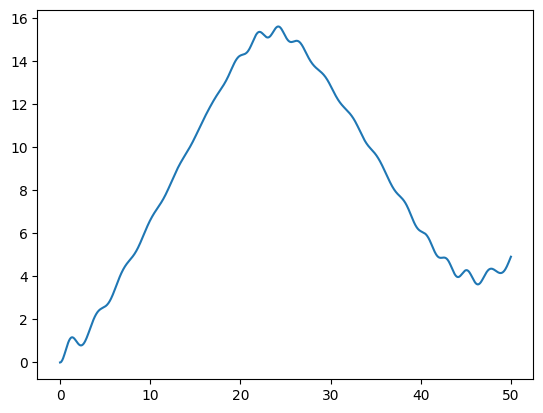

In [19]:
tiempos = np.linspace(0,50,1000)
complejidad = np.array([])

u_0 = Lanczos_Matrix[:,0]

for i in range(len(tiempos)):
    t = tiempos[i]
    u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

    if(Lanczos_Matrix.shape[0] == Lanczos_Matrix.shape[1]): coefs_phi_t = np.linalg.inv(Lanczos_Matrix)@u_t
    else: coefs_phi_t = np.linalg.pinv(Lanczos_Matrix)@u_t

    c_t = 0
    for n in range(len(coefs_phi_t)):
        c_t = c_t + n*np.abs(coefs_phi_t[n])**2
    complejidad = np.append(complejidad, c_t)
    
plt.plot(tiempos,complejidad)

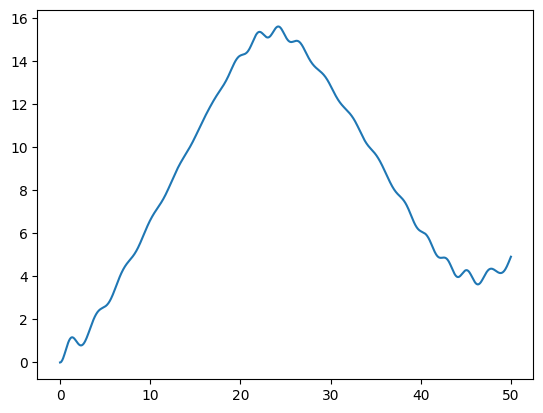

In [20]:
tiempos = np.linspace(0,50,1000)
complejidad = np.array([])

u_0 = Lanczos_Matrix[:,0]

for i in range(len(tiempos)):
    t = tiempos[i]
    u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

    c_t = 0
    for n in range(Lanczos_Matrix.shape[1]):
        c_t = c_t + n*np.abs(np.dot(u_t.T, Lanczos_Matrix[:,n]))**2
    complejidad = np.append(complejidad, c_t)
    
plt.plot(tiempos,complejidad)

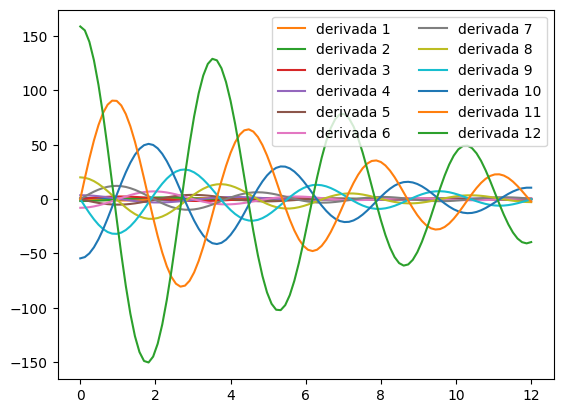

In [21]:
tiempos = np.linspace(0,12,100)
plt.plot(tiempos, [S(t_i) for t_i in tiempos])

M = [1]

for degree in range(1,13):
    
    Lprima = []
    for t in tiempos: 
        Lprima.append(derivative(S, x0 = t, dx= 0.3, n = degree , order = 6*degree + 1))
        
    plt.plot(tiempos, Lprima, label = f'derivada {degree}')
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.3, n = degree , order = 6*degree + 1))
    
plt.legend(loc = 'upper right', ncol=2)

In [22]:
a_coef(), a

([(2.0267002111788347e-08+4.04768811061255e-17j),
  (-3.9386815475613484e-08-1.389472001785922e-14j),
  (1.8202061834017894e-07+4.379145604883313e-11j),
  (-3.166240996032096e-07+4.762799368793249e-09j),
  (1.4546395010255538e-06-6.222040834464003e-06j),
  (-2.519236172936512e-06-0.005257184077415687j)],
 array([ 2.02670021e-08, -3.93868155e-08,  1.82020622e-07, -3.16624108e-07,
         1.45463539e-06, -2.51922660e-06,  1.14397667e-05, -1.96995260e-05,
         8.80903333e-05, -1.50534114e-04,  6.59004915e-04, -1.11395257e-03,
         4.72677756e-03, -7.85792598e-03,  3.17045867e-02, -5.12250880e-02,
         1.88294924e-01, -2.88033879e-01,  8.85629338e-01, -1.26271186e+00,
        -4.00000005e-01,  8.44444450e-01,  5.55555466e-02,  6.90006853e-09,
        -6.71386836e-09,  6.89192101e-09, -4.41602413e-09,  6.28696215e-09,
        -5.50490980e-09,  5.46909718e-09, -3.54857922e-09,  3.76995912e-09,
        -1.11472925e-10,  2.34154305e-10, -5.37381440e-10,  1.44797019e-10,
        -1

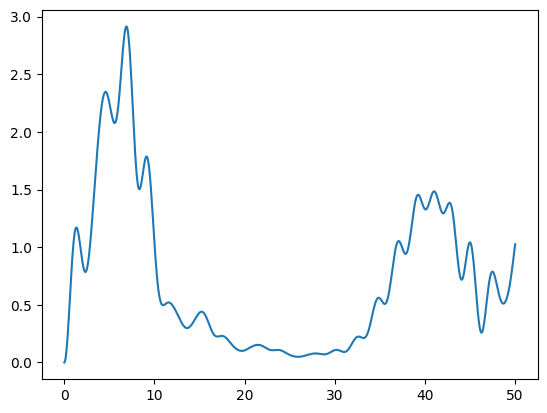

In [23]:
tiempos = np.linspace(0,50,1000)
complejidad = np.array([])

u_0 = Lanczos_Matrix[:,0]

for i in range(len(tiempos)):
    t = tiempos[i]
    u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

    c_t = 0
    for n in range(len(a_coef())):
        c_t = c_t + n*np.abs(np.dot(u_t.T, Lanczos_Matrix[:,n]))**2
    complejidad = np.append(complejidad, c_t)
    
plt.plot(tiempos,complejidad)

/tmp/ipykernel_1189/1790049417.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


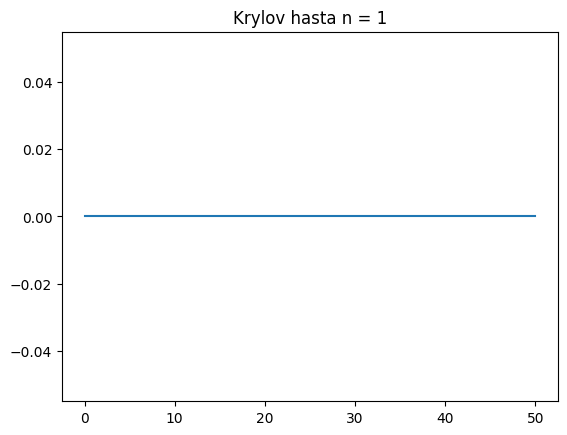

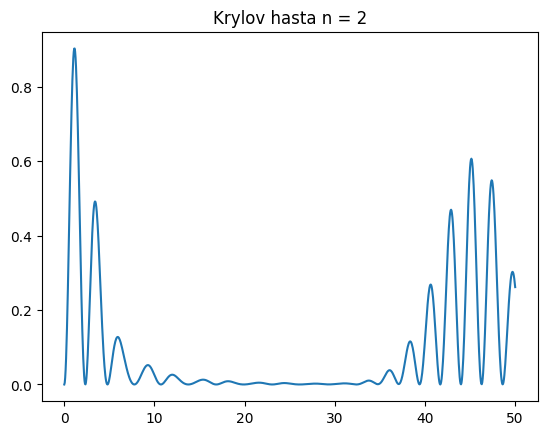

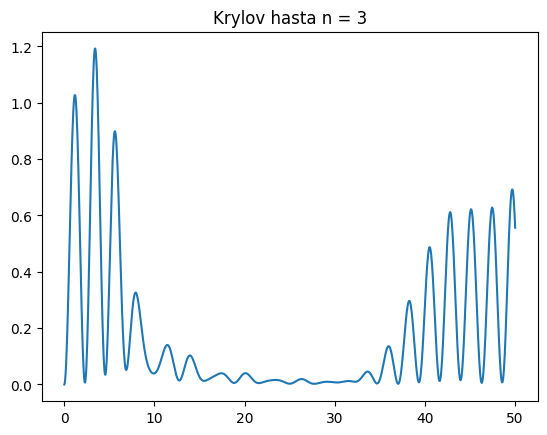

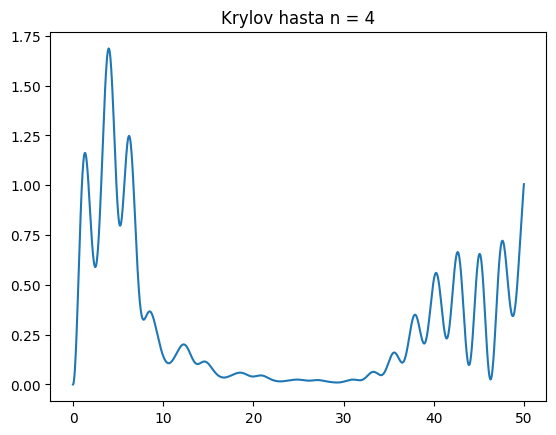

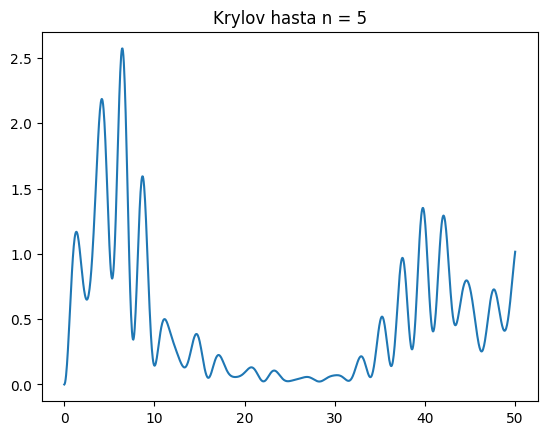

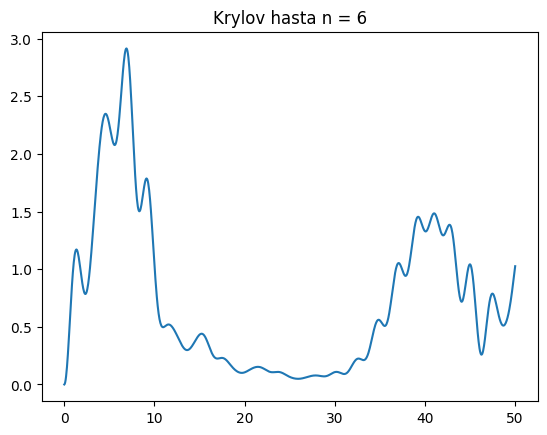

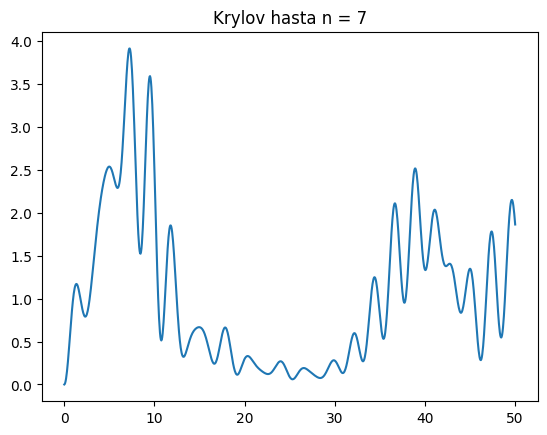

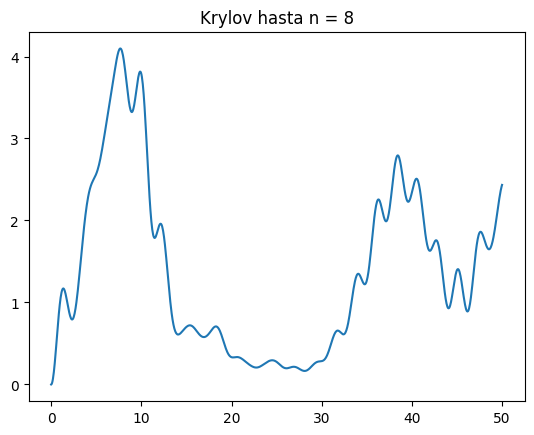

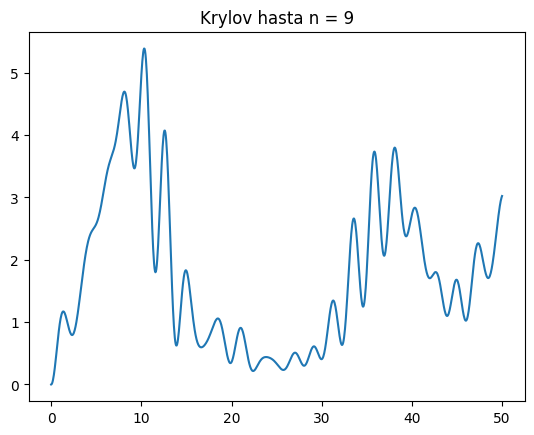

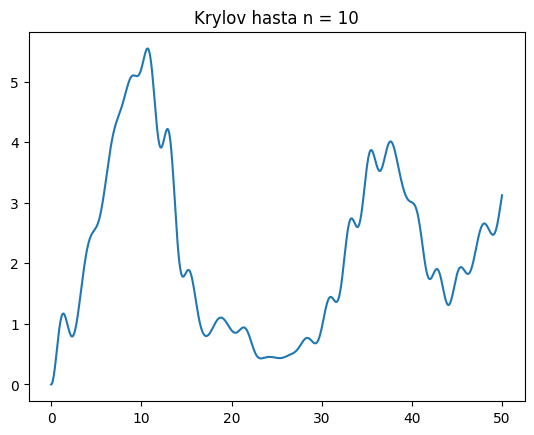

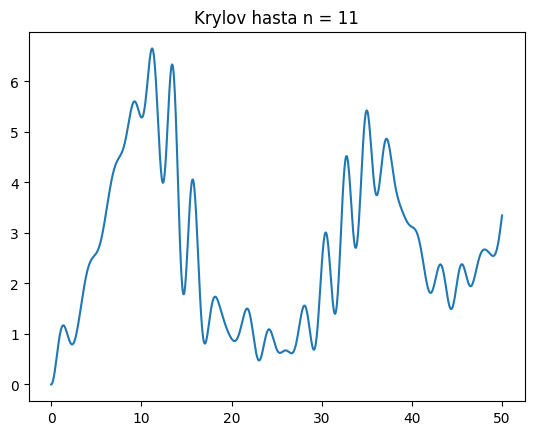

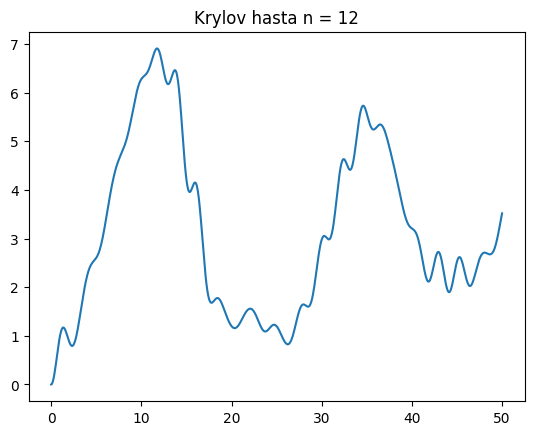

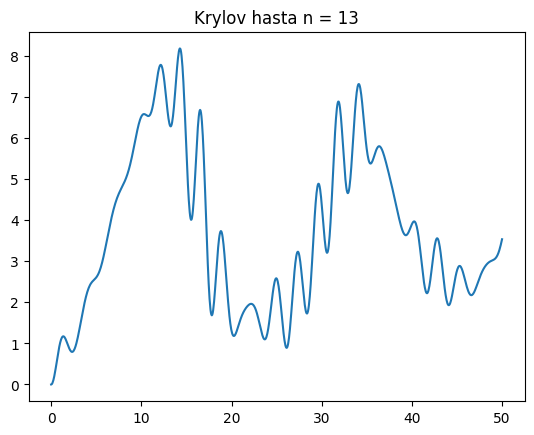

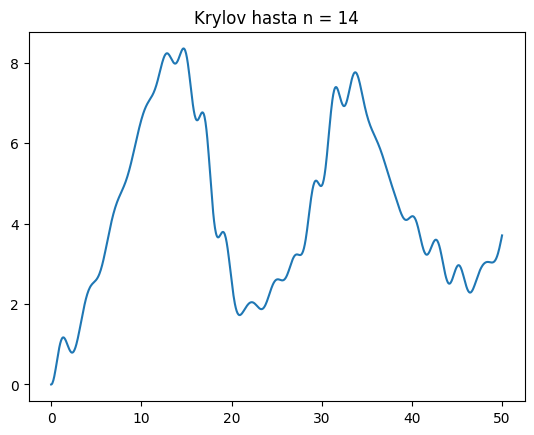

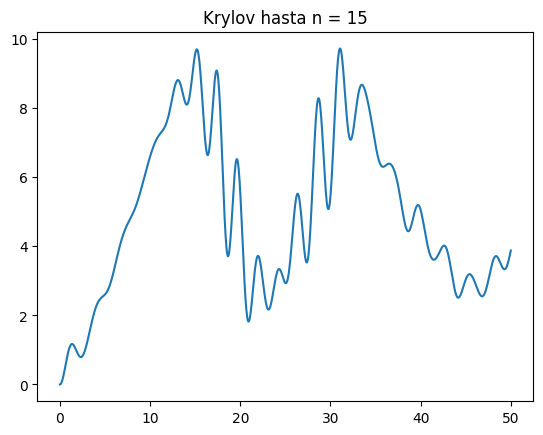

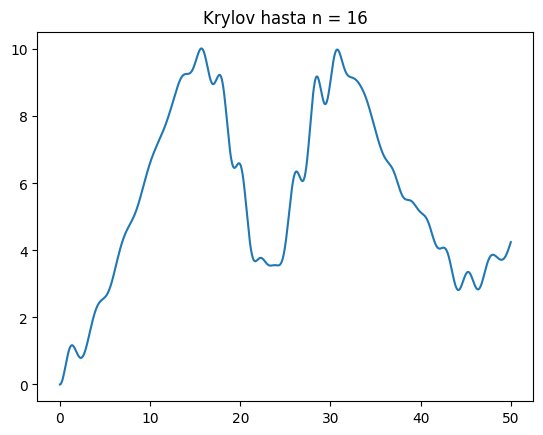

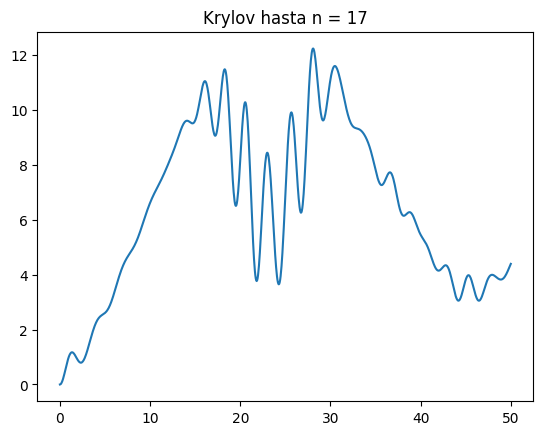

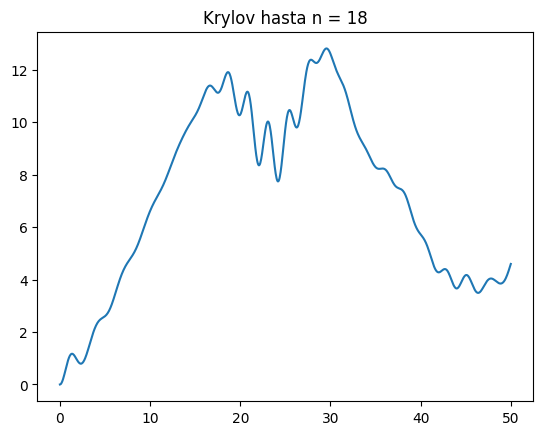

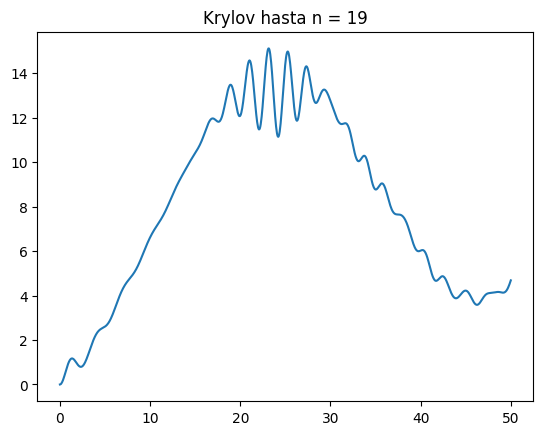

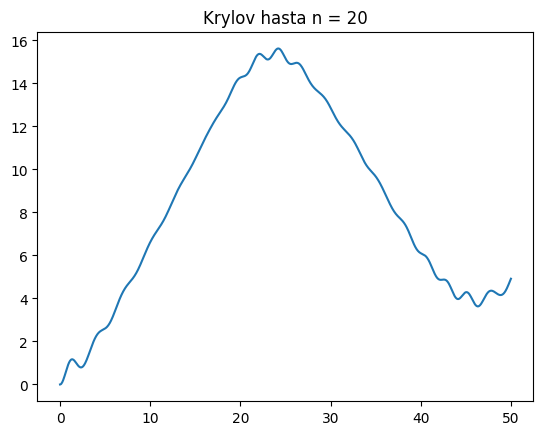

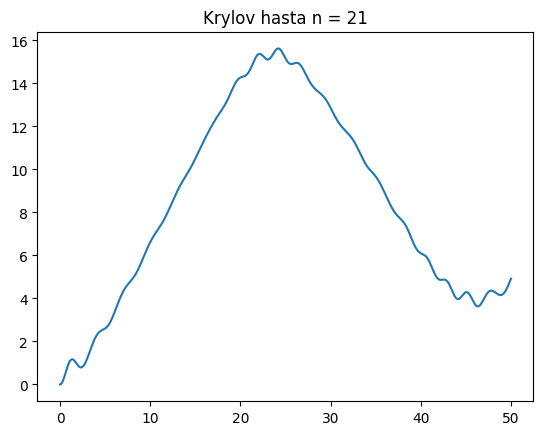

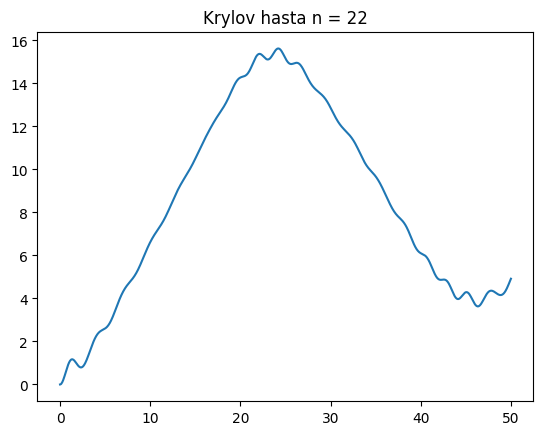

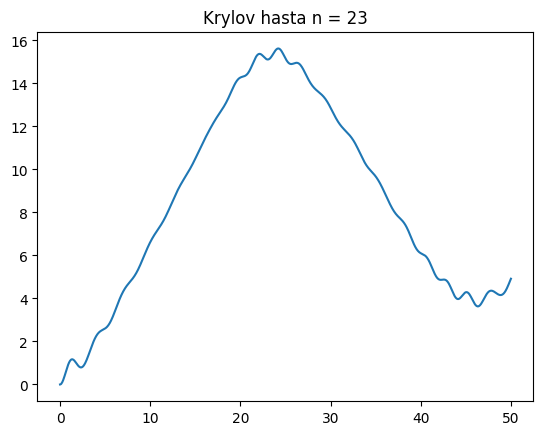

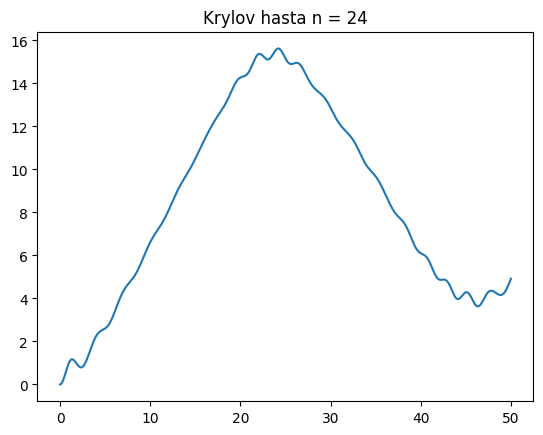

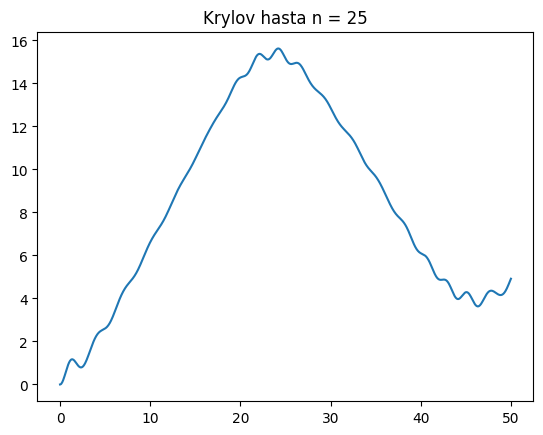

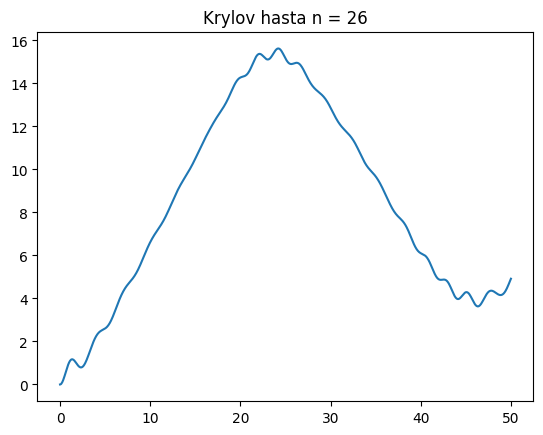

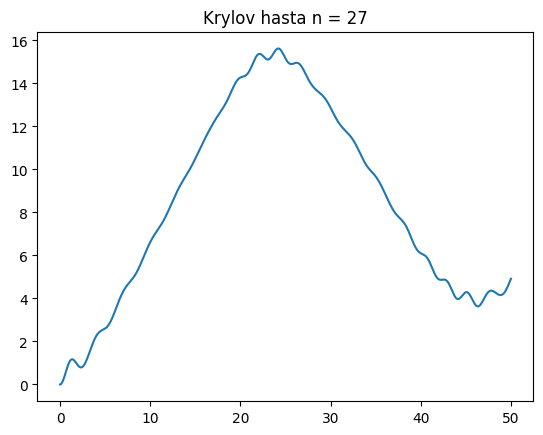

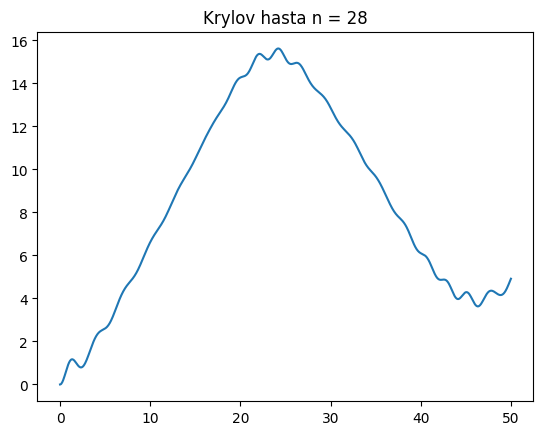

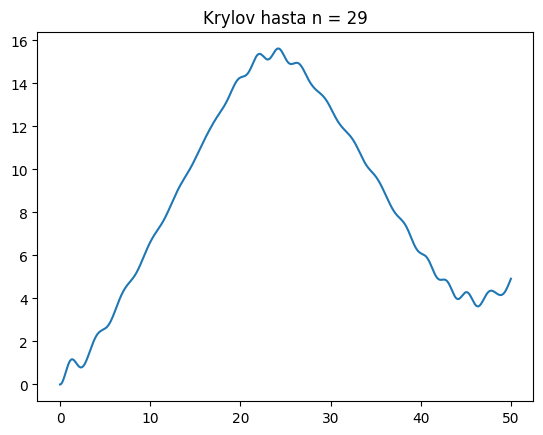

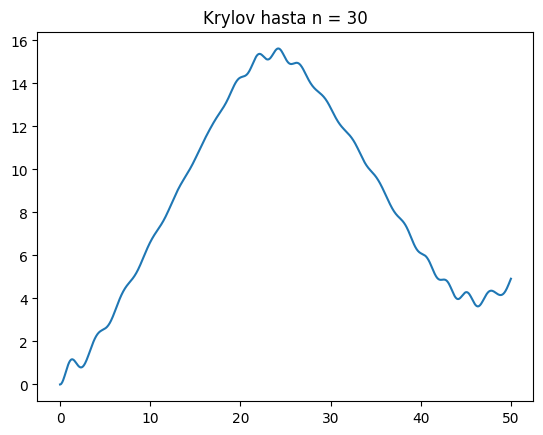

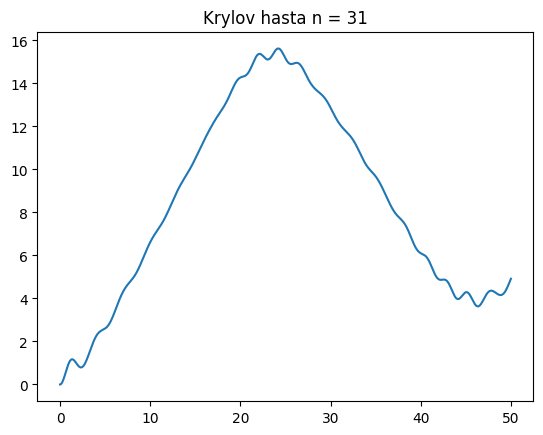

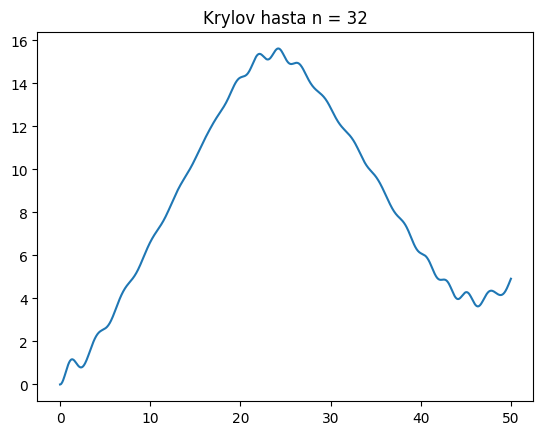

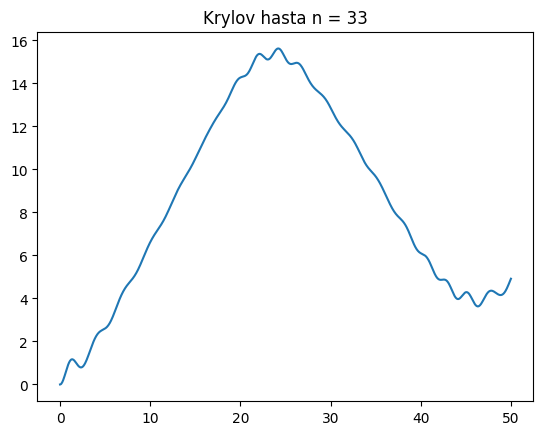

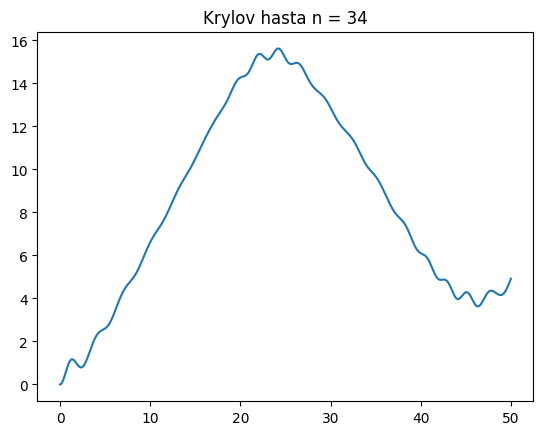

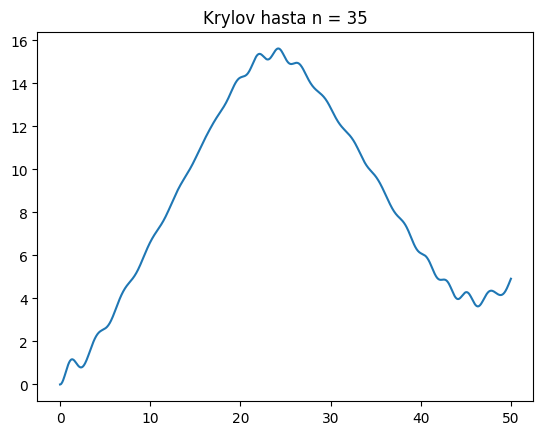

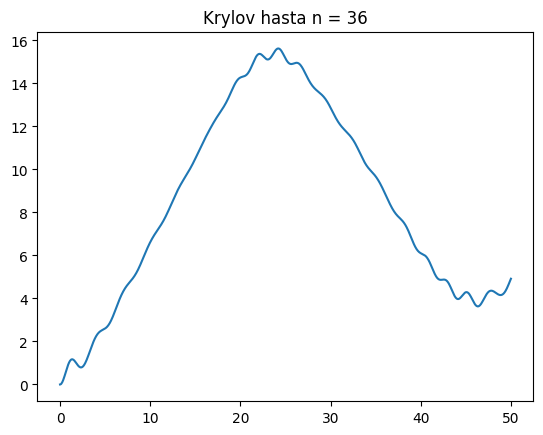

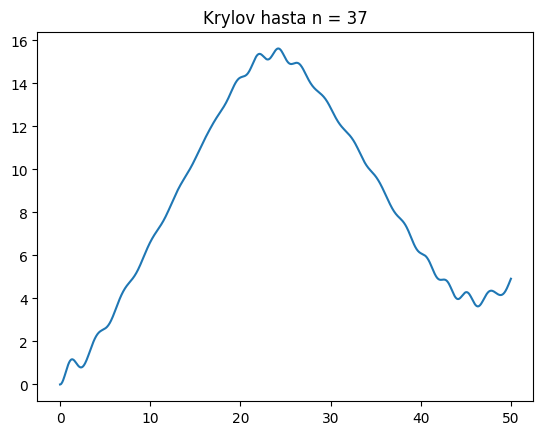

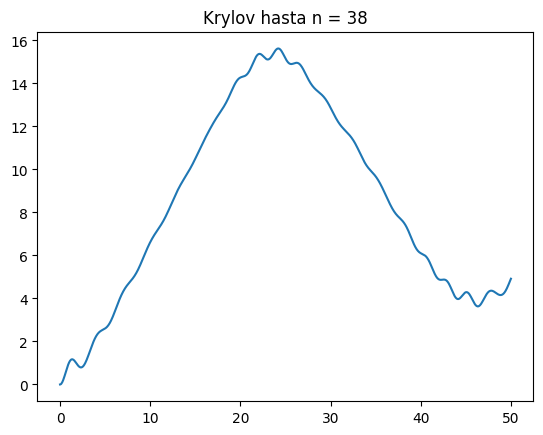

In [24]:
tiempos = np.linspace(0,50,1000)

u_0 = Lanczos_Matrix[:,0]

for j in range(1, len(a)):
    complejidad = np.array([])
    fig = plt.figure()
    for i in range(len(tiempos)):
        t = tiempos[i]
        u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

        c_t = 0
        for n in range(j):
            c_t = c_t + n*np.abs(np.dot(u_t.T, Lanczos_Matrix[:,n]))**2
        complejidad = np.append(complejidad, c_t)
        
    plt.plot(tiempos,complejidad)
    plt.title(f'Krylov hasta n = {j}')

In [25]:
N = 40 #Intentemos con N pequeños solo para ver que sucede
delta_i = 0.5
delta_f = -0.5

D_i, U_i, H_i = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_i, PBC = True))
D_f, U_f, H_f = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_f, PBC = True))

Vec_Est_Base = np.transpose(np.array([np.random.random(N)]))
# Vec_Est_Base, lambda_Base = Funciones.Estado_Base(D_i,U_i)

In [26]:
Lanczos_Matrix, a, b, H = M_Lanczos(N, H_f, Vec_Est_Base)

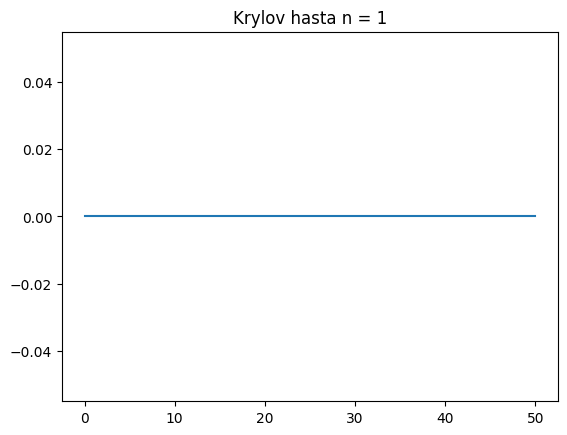

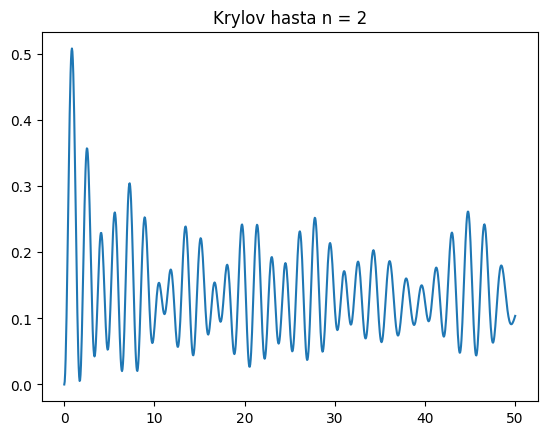

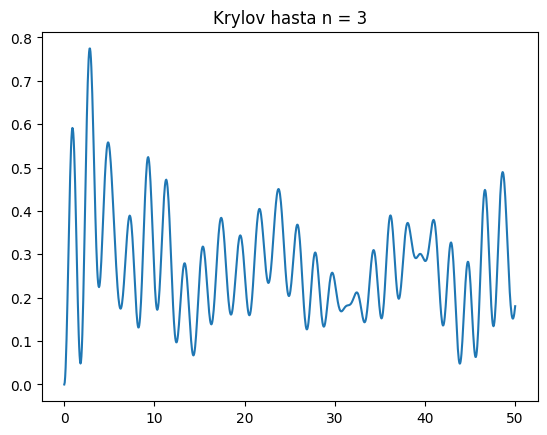

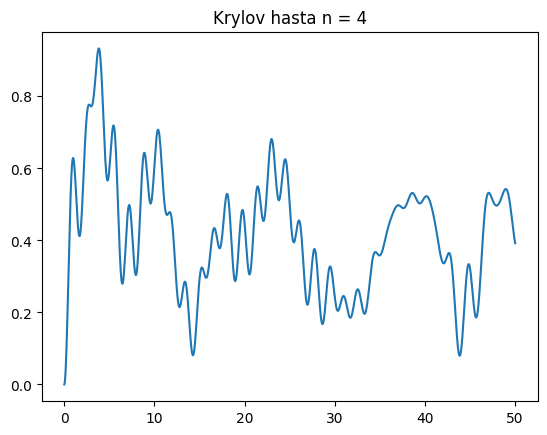

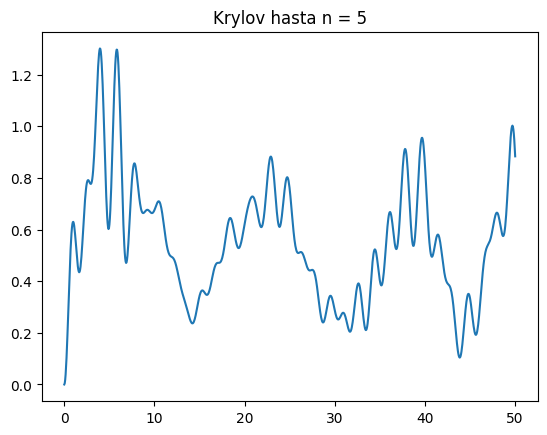

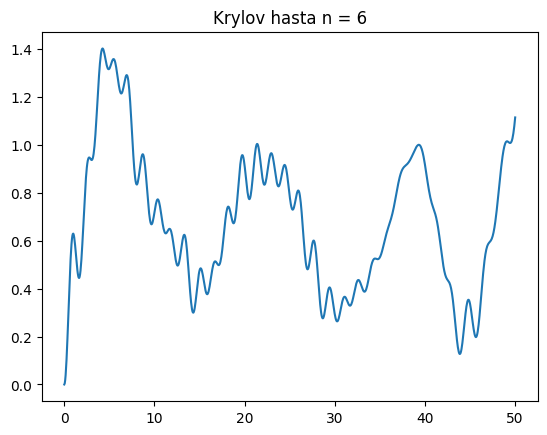

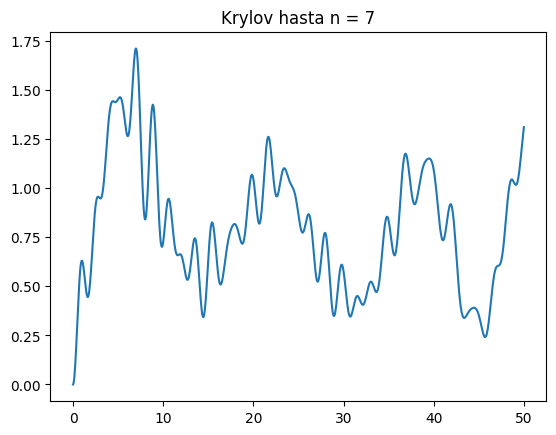

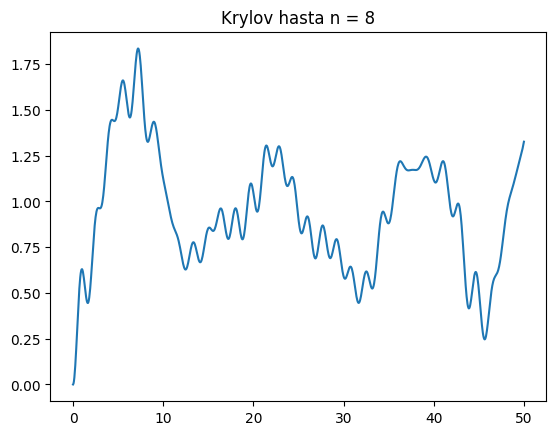

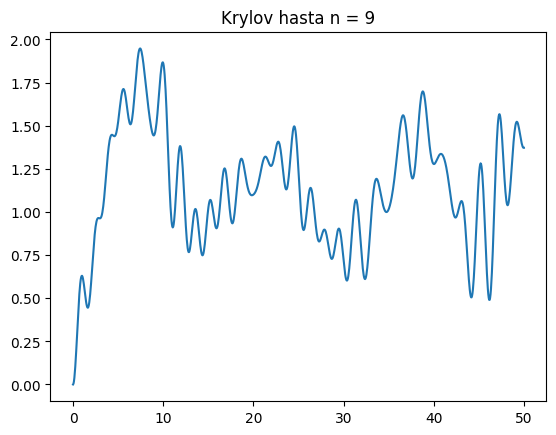

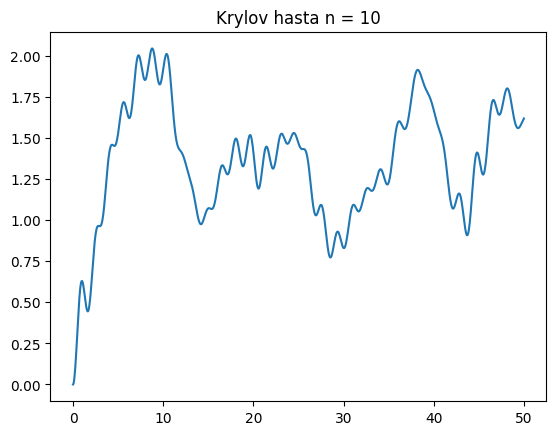

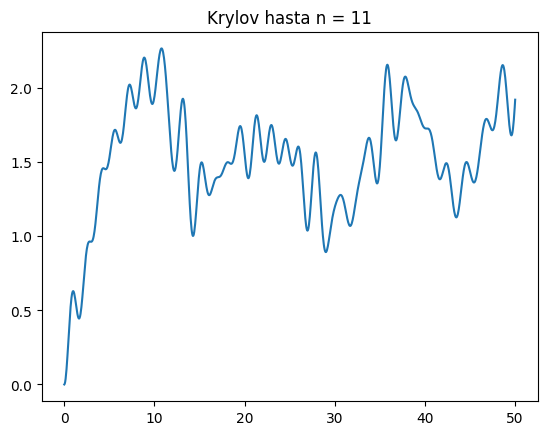

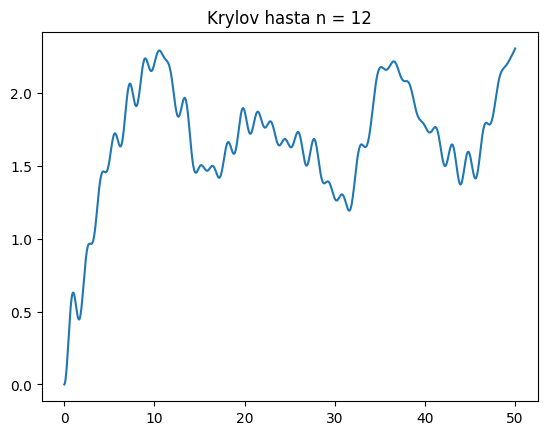

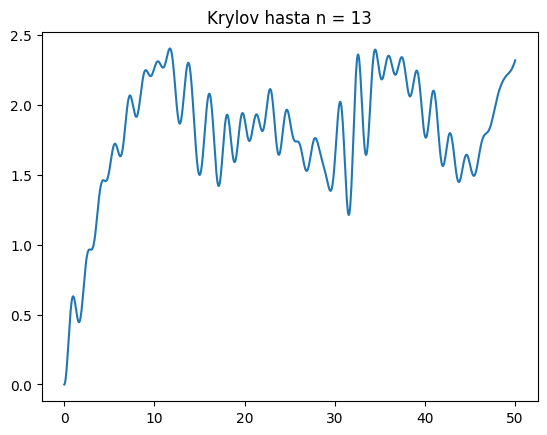

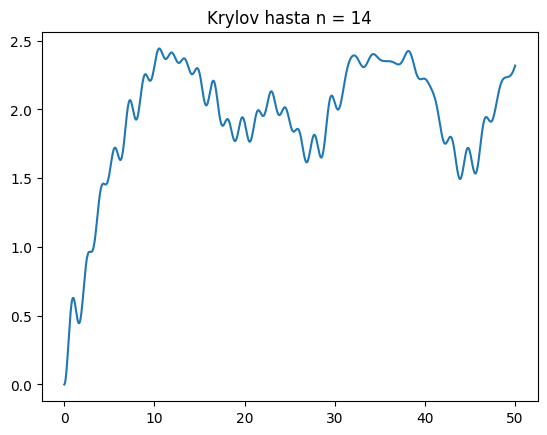

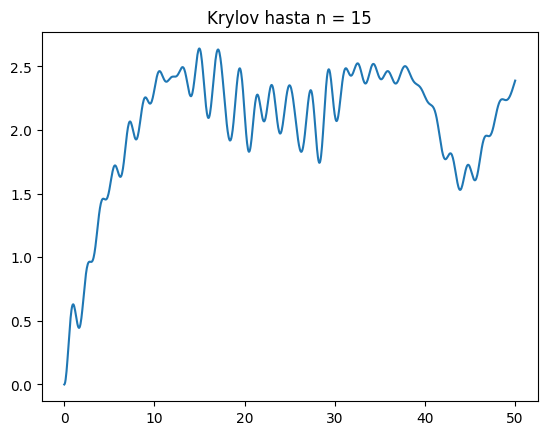

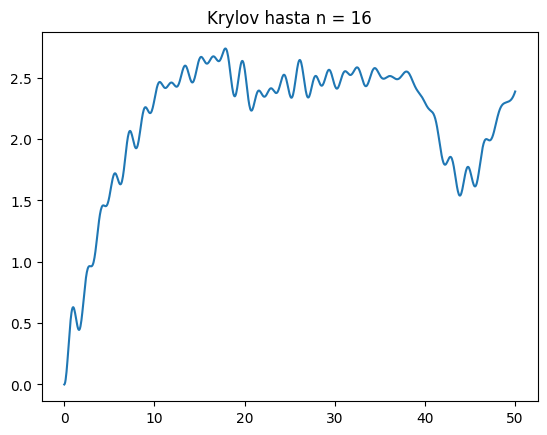

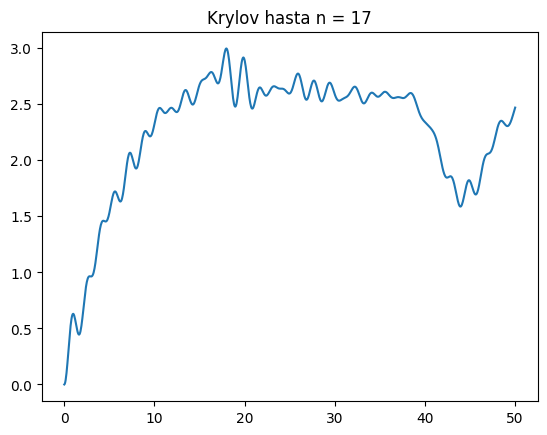

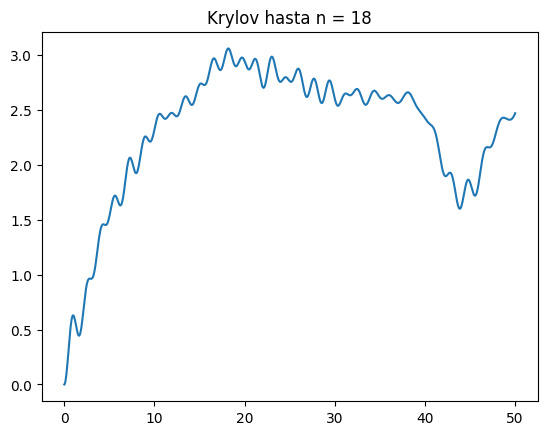

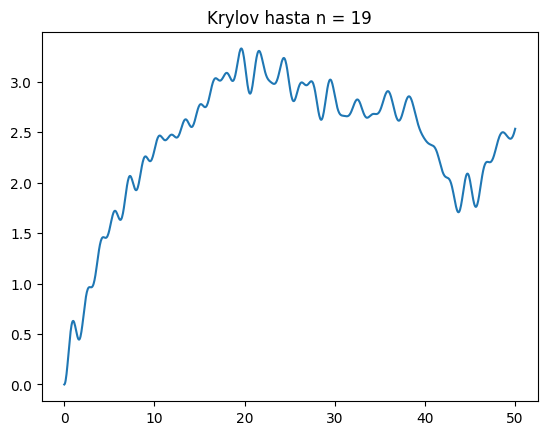

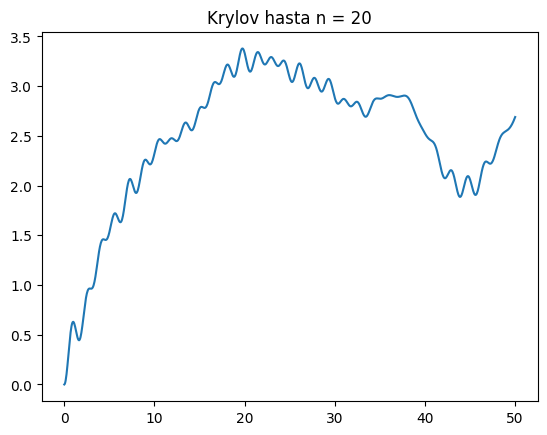

In [28]:
tiempos = np.linspace(0,50,1000)

u_0 = Lanczos_Matrix[:,0]

for j in range(1, len(a)):
    complejidad = np.array([])
    fig = plt.figure()
    for i in range(len(tiempos)):
        t = tiempos[i]
        u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

        c_t = 0
        for n in range(j):
            c_t = c_t + n*np.abs(np.dot(u_t.T, Lanczos_Matrix[:,n]))**2
        complejidad = np.append(complejidad, c_t)
        
    plt.plot(tiempos,complejidad)
    plt.title(f'Krylov hasta n = {j}')

In [29]:
N = 40 #Intentemos con N pequeños solo para ver que sucede
delta_i = -0.5
delta_f = 0.5

D_i, U_i, H_i = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_i, PBC = True))
D_f, U_f, H_f = Funciones.Diagonalizar(Funciones.H_t1_t2(N, delta_f, PBC = True))

# Vec_Est_Base = np.transpose(np.array([np.random.random(N)]))
# Vec_Est_Base, lambda_Base = Funciones.Estado_Base(D_i,U_i)

In [30]:
Lanczos_Matrix, a, b, H = M_Lanczos(N, H_f, Vec_Est_Base)

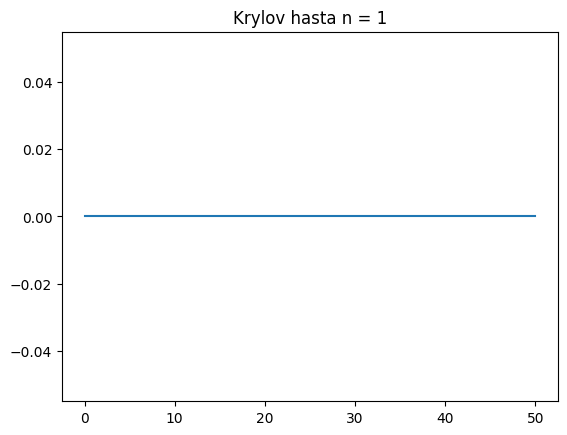

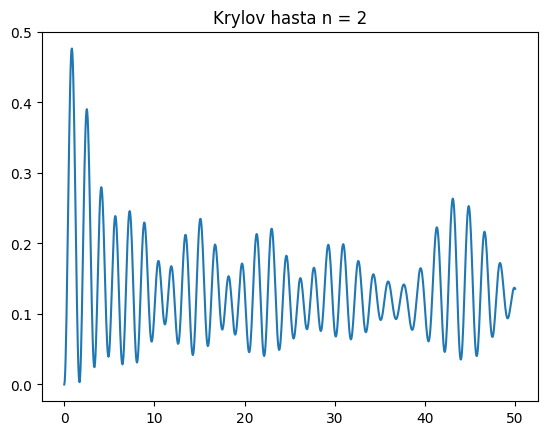

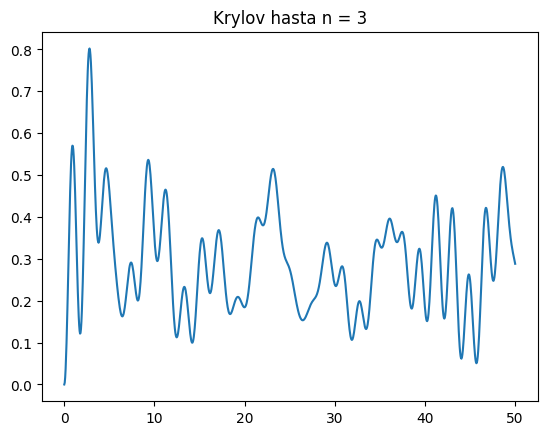

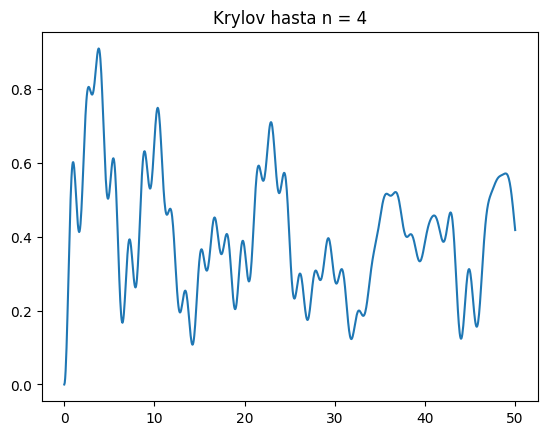

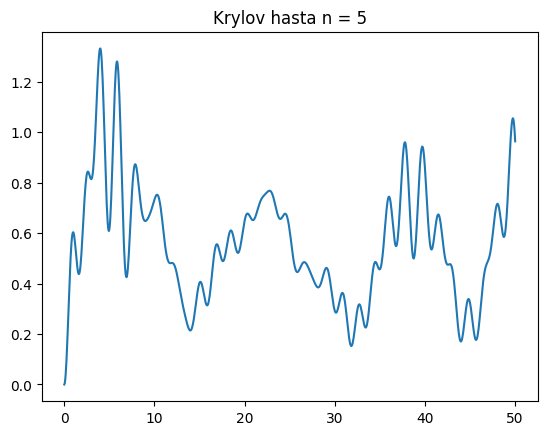

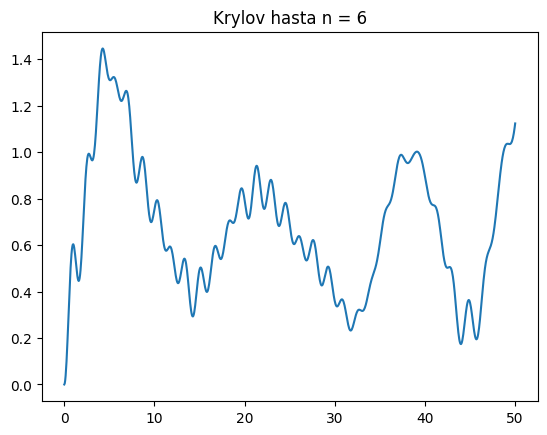

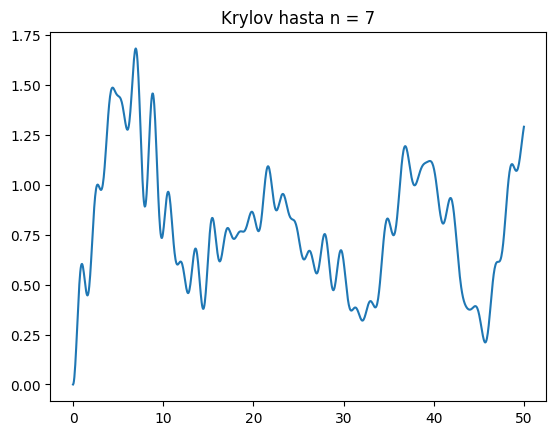

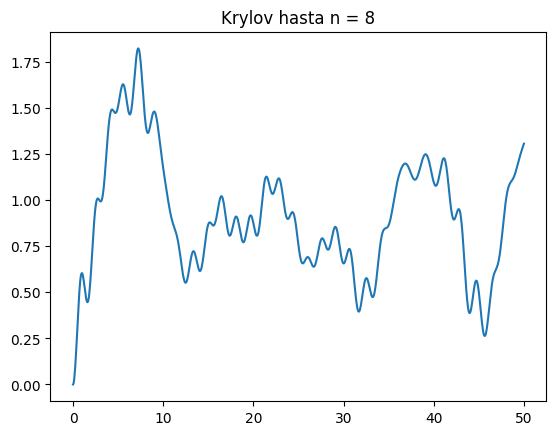

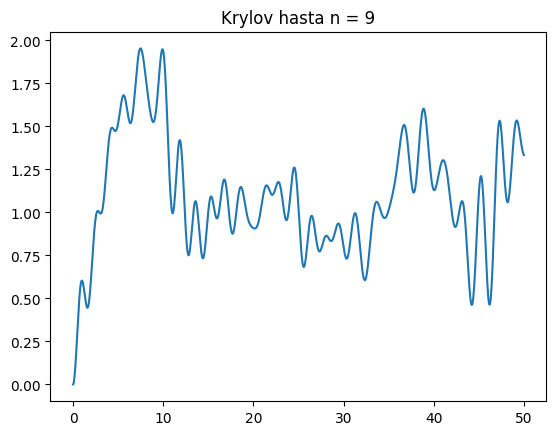

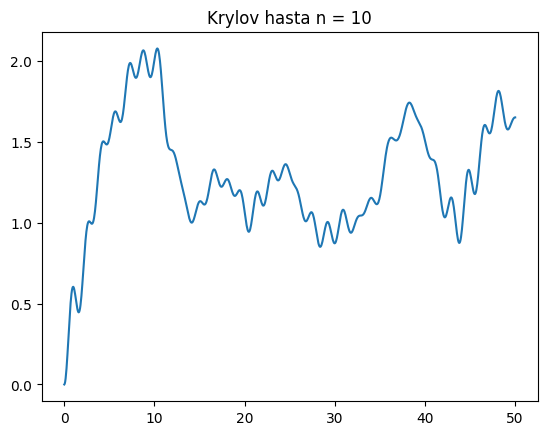

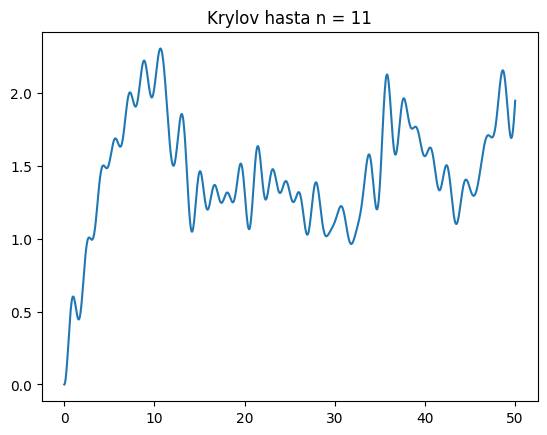

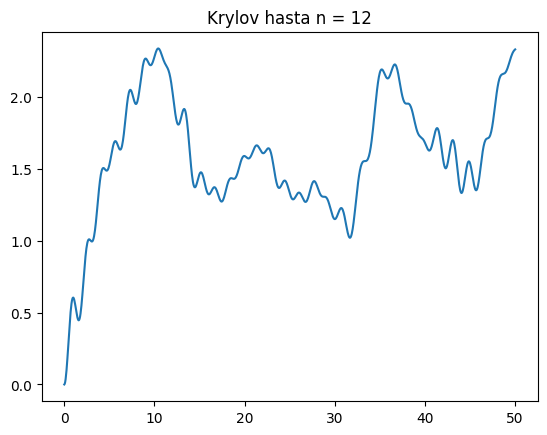

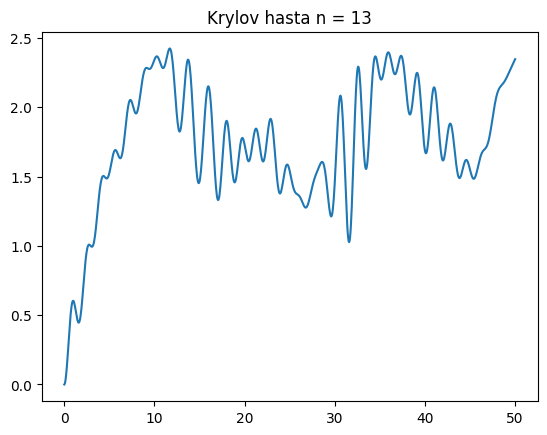

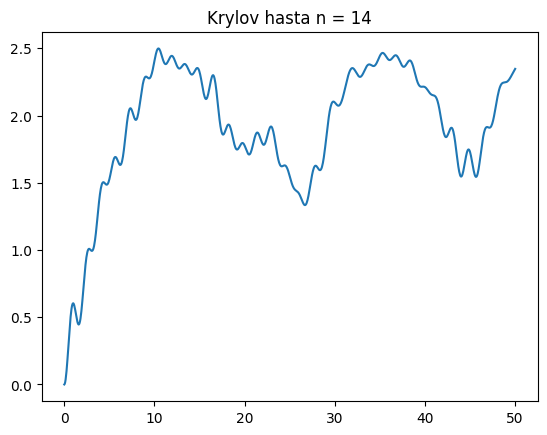

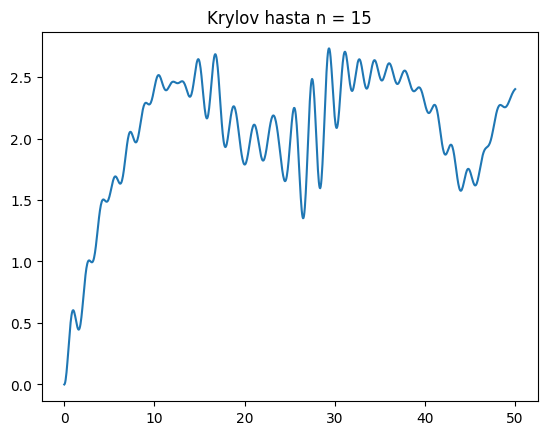

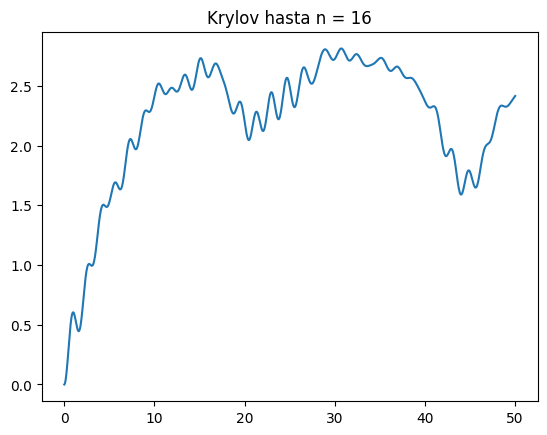

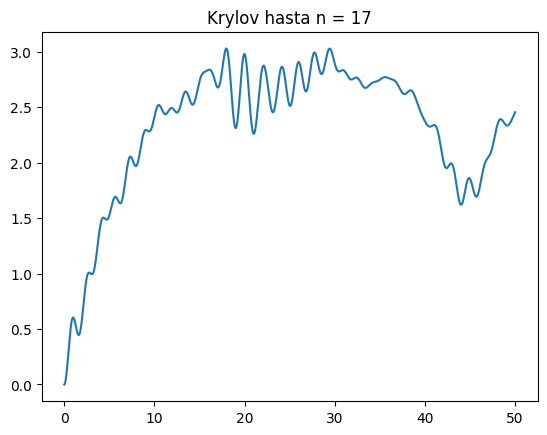

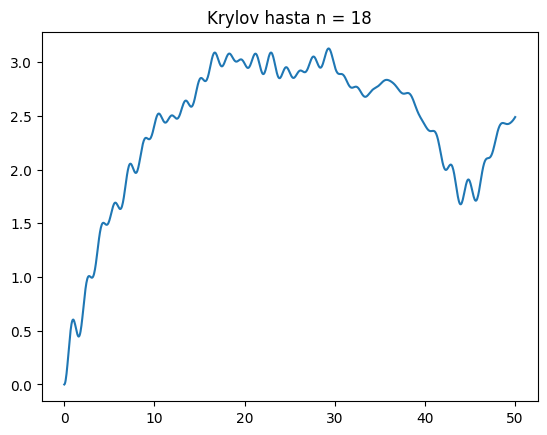

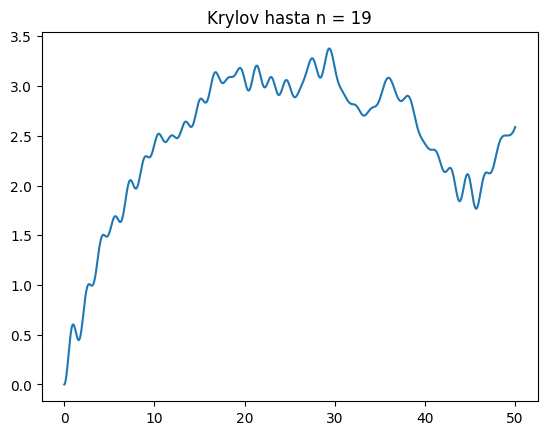

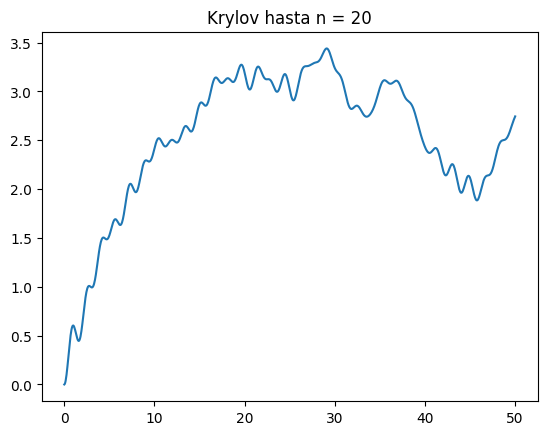

In [31]:
tiempos = np.linspace(0,50,1000)

u_0 = Lanczos_Matrix[:,0]

for j in range(1, len(a)):
    complejidad = np.array([])
    fig = plt.figure()
    for i in range(len(tiempos)):
        t = tiempos[i]
        u_t = np.dot(linalg.expm((-1j)*H*t), u_0)

        c_t = 0
        for n in range(j):
            c_t = c_t + n*np.abs(np.dot(u_t.T, Lanczos_Matrix[:,n]))**2
        complejidad = np.append(complejidad, c_t)
        
    plt.plot(tiempos,complejidad)
    plt.title(f'Krylov hasta n = {j}')